In [81]:
import cv2 as cv
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score

In [23]:
class_label_encoding = {
    'SPOILED': 0,
    'HALF': 1,
    'FRESH': 2
}

# Loading Images

In [26]:
def load_images(file_path, output_x, output_y):
    for file_name in os.listdir(file_path):
        class_name = file_name.split('-')[0]
        if (class_name == '_classes.csv'): continue
        img = cv.imread(file_path + file_name).astype('float32')
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = cv.resize(img, (128, 128), interpolation = cv.INTER_AREA)
        img /= 255
        output_x.append(img)
        output_y.append(class_label_encoding[class_name])

In [28]:
train_x = []
train_y = []
test_x = []
test_y = []

load_images('data/train/', train_x, train_y)
load_images('data/train/', test_x, test_y)

In [29]:
train_x[0]

array([[[0.941107  , 0.7227521 , 0.63253284],
        [0.905836  , 0.66376615, 0.5901613 ],
        [0.8671308 , 0.6055923 , 0.5416406 ],
        ...,
        [0.41174155, 0.2824922 , 0.2447152 ],
        [0.30335307, 0.17540318, 0.13040957],
        [0.2381483 , 0.12477086, 0.07030979]],

       [[0.9292263 , 0.7146305 , 0.6227405 ],
        [0.86221147, 0.6221372 , 0.5481611 ],
        [0.86638826, 0.6069381 , 0.5429864 ],
        ...,
        [0.3790695 , 0.25868428, 0.22141781],
        [0.27922034, 0.15572573, 0.11453766],
        [0.20547628, 0.09228449, 0.04394942]],

       [[0.91760075, 0.7106393 , 0.61738026],
        [0.87935954, 0.647987  , 0.5713424 ],
        [0.85557497, 0.6022509 , 0.5370228 ],
        ...,
        [0.3851259 , 0.27868664, 0.24494724],
        [0.30804038, 0.19197124, 0.15333566],
        [0.2248289 , 0.11418958, 0.06975288]],

       ...,

       [[0.31880733, 0.21684651, 0.12665044],
        [0.30929345, 0.20733266, 0.11713655],
        [0.3095255 , 0

# Color Histogram

In [54]:
def extract_color_histogram(image, bins=32):
    """
    Extract color histogram features from an image.
    
    Parameters:
    - image: The input image (should be in RGB format)
    - bins: Number of bins for the histogram
    
    Returns:
    - histogram_features: Flattened histogram features
    """
    # Extract histograms for each channel
    hist_r = cv.calcHist([image], [0], None, [bins], [0, 1])  # Changed range to [0, 1] since you're normalizing images
    hist_g = cv.calcHist([image], [1], None, [bins], [0, 1])
    hist_b = cv.calcHist([image], [2], None, [bins], [0, 1])
    
    # Normalize the histograms
    cv.normalize(hist_r, hist_r, 0, 1, cv.NORM_MINMAX)
    cv.normalize(hist_g, hist_g, 0, 1, cv.NORM_MINMAX)
    cv.normalize(hist_b, hist_b, 0, 1, cv.NORM_MINMAX)
    
    # Flatten and concatenate the histograms
    histogram_features = np.concatenate([
        hist_r.flatten(), 
        hist_g.flatten(), 
        hist_b.flatten()
    ])
    
    return histogram_features

In [56]:
def plot_color_histogram(image, bins=32, title="Color Histogram"):
    """
    Plot the color histogram of an image.
    
    Parameters:
    - image: The input image (should be in RGB format)
    - bins: Number of bins for the histogram
    - title: Title for the plot
    
    Returns:
    - None (displays the plot)
    """
    # Create a figure with subplots
    fig, ax = plt.subplots(1, 4, figsize=(16, 4))
    
    # Display the original image
    ax[0].imshow(image)
    ax[0].set_title('Original Image')
    ax[0].axis('off')
    
    # Get histogram features using your existing function
    features = extract_color_histogram(image, bins)
    
    # Split the features back into channels
    channel_length = len(features) // 3
    hist_r = features[:channel_length].reshape(bins, 1)
    hist_g = features[channel_length:2*channel_length].reshape(bins, 1)
    hist_b = features[2*channel_length:].reshape(bins, 1)
    
    # Define colors and channels
    colors = ['r', 'g', 'b']
    channels = ['Red', 'Green', 'Blue']
    hists = [hist_r, hist_g, hist_b]
    
    # Plot histograms for each channel
    for i, (hist, col, chan) in enumerate(zip(hists, colors, channels)):
        ax[i+1].plot(hist, color=col)
        ax[i+1].set_xlim([0, bins])
        ax[i+1].set_title(f'{chan} Histogram')
        ax[i+1].set_xlabel('Bins')
        ax[i+1].set_ylabel('# of Pixels')
        ax[i+1].grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()
    
    return features

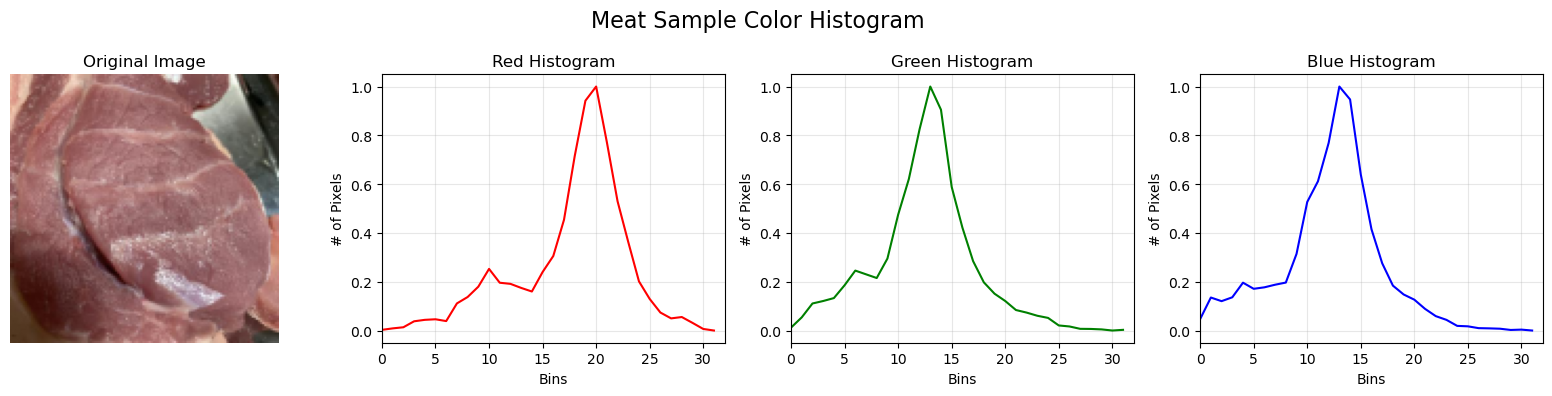

In [64]:
image = train_x[0]  # Get the first image
plot_color_histogram(image, bins=32, title="Meat Sample Color Histogram")
print()

In [93]:
# Extract features from training and testing sets
train_features = []
for img in train_x:
    hist_features = extract_color_histogram(img)
    train_features.append(hist_features)
train_features = np.array(train_features)


test_features = []
for img in test_x:
    hist_features = extract_color_histogram(img)
    test_features.append(hist_features)
test_features = np.array(test_features)

print(train_features)

[[2.7649770e-03 8.7557603e-03 1.3364055e-02 ... 2.3234200e-03
  3.7174721e-03 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 2.3536896e-02 ... 4.0192925e-03
  1.6077170e-03 0.0000000e+00]
 [2.0098522e-01 9.9014781e-02 3.8916256e-02 ... 1.6547159e-03
  0.0000000e+00 0.0000000e+00]
 ...
 [1.2801204e-02 3.5391565e-02 4.7439758e-02 ... 2.4834438e-03
  8.2781457e-04 0.0000000e+00]
 [6.5093571e-03 2.0341741e-02 4.0683482e-02 ... 2.0517394e-02
  1.1641532e-10 1.7841214e-03]
 [3.2509752e-03 6.5019503e-03 1.0403121e-02 ... 6.1559509e-03
  0.0000000e+00 0.0000000e+00]]


# Decision Tree

In [113]:
def train_decision_tree(x_train_tree, y_train_tree, x_test_tree, y_test_tree, max_depth=5, show_tree=True, feature_names=None):
    """
    Train a decision tree classifier on any type of features, with optional histogram visualization.
    
    Parameters:
    - x_train_tree: Training features
    - y_train_tree: Training labels
    - x_test_tree: Test features
    - y_test_tree: Test labels
    - max_depth: Maximum depth of the decision tree
    - show_tree: Whether to visualize the decision tree
    - feature_names: Names of features (will be auto-generated if None)
    
    Returns:
    - dt_classifier: Trained decision tree classifier
    - accuracy: Classification accuracy on test set
    - report: Classification report
    """

    # Create a list of class names
    class_names=['SPOILED', 'HALF', 'FRESH']
    
    # Create and train a Decision Tree classifier
    dt_classifier = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    dt_classifier.fit(x_train_tree, y_train_tree)
    
    # Make predictions
    predictions = dt_classifier.predict(x_test_tree)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test_tree, predictions)
    report = classification_report(y_test_tree, predictions, target_names=class_names)
    
    # Print results
    print(f"Decision Tree Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(report)
    
    # Show decision tree if requested
    if show_tree:
        # Create feature names if not provided
        if feature_names is None:
            feature_names = [f"Feature_{i}" for i in range(x_train_tree.shape[1])]
            
        plt.figure(figsize=(15, 10))
        plot_tree(dt_classifier, 
                  feature_names=feature_names,
                  class_names=class_names,
                  filled=True, 
                  rounded=True, 
                  fontsize=8)
        plt.title("Decision Tree for Classification")
        plt.tight_layout()
        plt.show()
    
    return dt_classifier, accuracy, report

Decision Tree Accuracy: 0.7063

Classification Report:
              precision    recall  f1-score   support

     SPOILED       0.89      0.70      0.78       510
        HALF       0.69      0.62      0.65       630
       FRESH       0.63      0.79      0.70       675

    accuracy                           0.71      1815
   macro avg       0.74      0.70      0.71      1815
weighted avg       0.72      0.71      0.71      1815



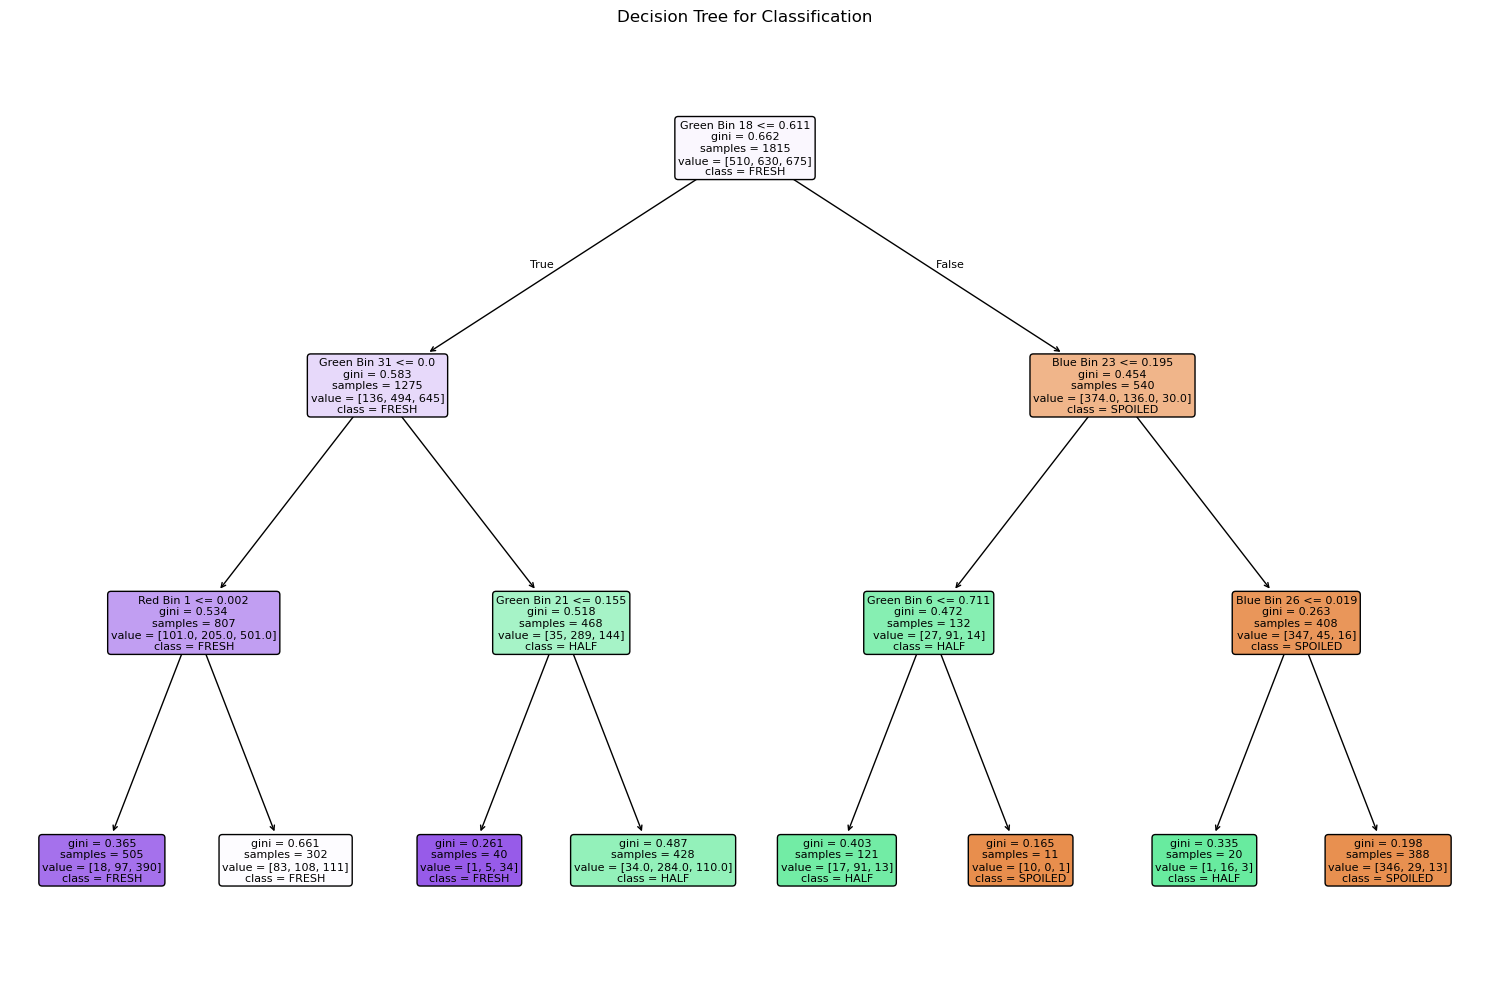

In [115]:
# Create feature names for the histogram features
bins_per_channel = train_features.shape[1] // 3
channels = ['Red', 'Green', 'Blue']
feature_names = []
for channel in channels:
    for index in range(bins_per_channel):
        feature_names.append(f"{channel} Bin {index}")

#x_train_tree, y_train_tree, x_test_tree, y_test_tree, max_depth=5, show_tree=True, feature_names=None

# Train the decision tree with histogram visualization
model, acc, report = train_decision_tree(x_train_tree=train_features, y_train_tree=train_y, x_test_tree=test_features,
                                         y_test_tree=test_y, max_depth=3, feature_names=feature_names)